In [1]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [4]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

def read_timeseries(filename):
    print("oppening %s"%filename)
    h5file=h5py.File(filename)
    data_dict=dict()
    for k in h5file.keys():
        units=h5file[k].attrs['units']
        data_dict["%s (%s)"%(k.replace("_"," "),units)]=h5file[k][:]
    df_tmp=pd.DataFrame(data_dict)
    df_tmp=df_tmp.drop(columns=[x for x in df_tmp.columns if "group" in x])
    df_tmp['time (ns)']=df_tmp['time (ps)']*0.001
    return df_tmp

def read_dos(filename,emin,emax,apply_broadening=False):
    h5file=h5py.File(filename)
    data_dict=dict()
    omega_shape=h5file["omega"][:].shape
    for k in h5file.keys():
        data_array=h5file[k][:]
        if data_array.shape != omega_shape or "_0" in k:
            continue
        units=h5file[k].attrs['units']
        data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
    df_tmp=pd.DataFrame(data_dict).query("%f <= `omega (rad/ps)` and `omega (rad/ps)` < %f"%(emin/0.6582,emax/0.6582))
    df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
    if apply_broadening:
        df_tmp['dos total (nm2/ps)']=apply_gaussian_broadening(df_tmp)
    df_tmp["Phonon Density of States"]=df_tmp['dos total (nm2/ps)']/df_tmp['dos total (nm2/ps)'].max()
    return df_tmp

oppening ../results/lammps/convergence/2nm/simulation_time/results/st_2500/mdanse/nvt_prod_100K_rmsd.h5
oppening ../results/lammps/convergence/2nm/timestep/results/dt_0.001/mdanse/nvt_prod_100K_rmsd.h5
oppening ../results/lammps/convergence/2nm/simulation_time/results/st_10000/mdanse/nvt_prod_100K_rmsd.h5
oppening ../results/lammps/convergence/2nm/simulation_time/results/st_15000/mdanse/nvt_prod_100K_rmsd.h5
oppening ../results/lammps/convergence/2nm/simulation_time/results/st_2500/mdanse/nvt_prod_100K_ecc.h5
oppening ../results/lammps/convergence/2nm/timestep/results/dt_0.001/mdanse/nvt_prod_100K_ecc.h5
oppening ../results/lammps/convergence/2nm/simulation_time/results/st_10000/mdanse/nvt_prod_100K_ecc.h5
oppening ../results/lammps/convergence/2nm/simulation_time/results/st_15000/mdanse/nvt_prod_100K_ecc.h5


,Time (ps),Radius (nm),Simulation Time (ns),Time (ns)
0,0,1.56556,2.5,0.000
1,1,1.56504,2.5,0.001
2,2,1.56549,2.5,0.002
3,3,1.56539,2.5,0.003
4,4,1.56516,2.5,0.004
...,...,...,...,...
32495,14995,1.56539,15.0,14.995
32496,14996,1.56500,15.0,14.996
32497,14997,1.56545,15.0,14.997
32498,14998,1.56546,15.0,14.998


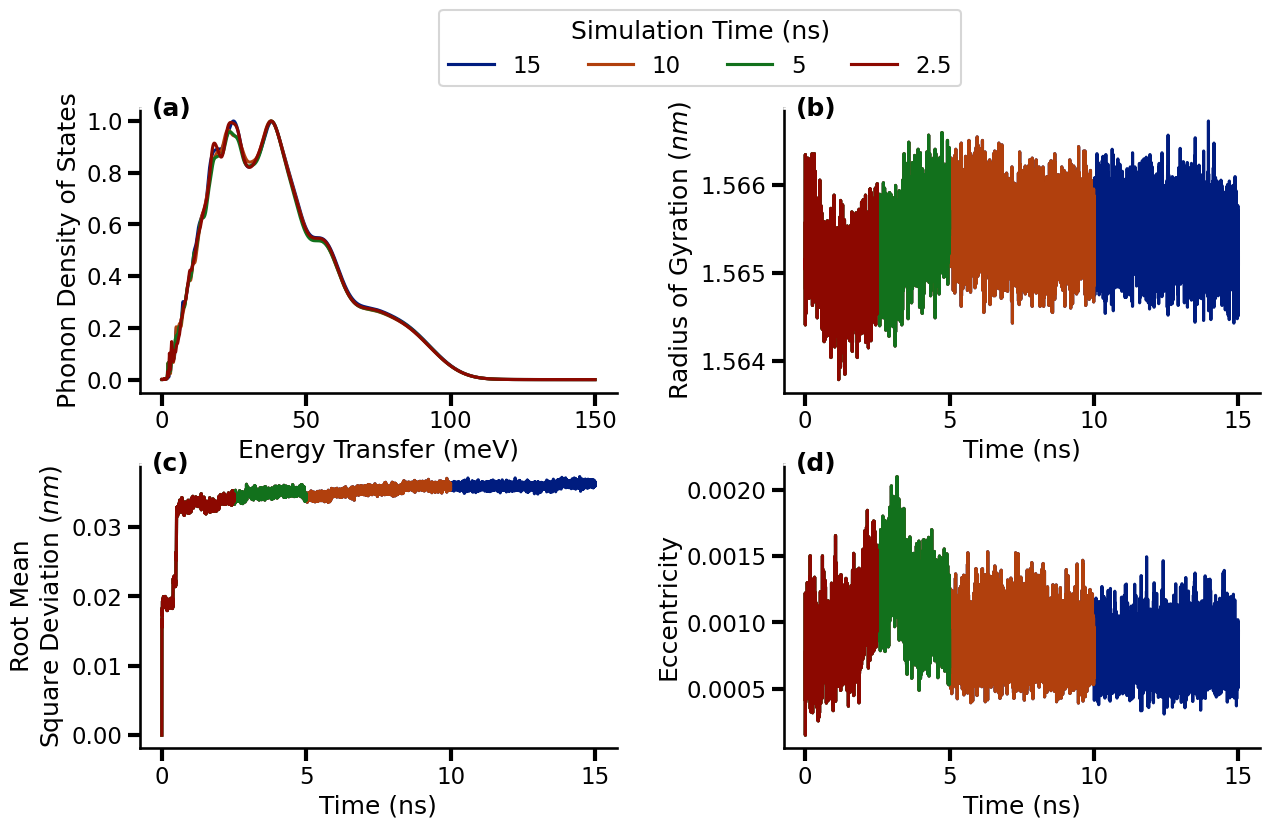

In [6]:
emin=0
emax=150


data_directrory={
               2.5:"../results/lammps/convergence/2nm/simulation_time/results/st_2500/mdanse/",
               5:"../results/lammps/convergence/2nm/timestep/results/dt_0.001/mdanse/",
               10:"../results/lammps/convergence/2nm/simulation_time/results/st_10000/mdanse/",
               15:"../results/lammps/convergence/2nm/simulation_time/results/st_15000/mdanse/",
               
}


df_list=list()
for simulation_time,directory in data_directrory.items():
    df_tmp=read_dos(directory+"nvt_phonon_100K_dos.h5",emin,emax,apply_broadening=True)
    df_tmp["Simulation Time (ns)"]=simulation_time
    df_list.append(df_tmp)
df_dos_time=pd.concat(df_list,ignore_index=True)


df_list=list()
for simulation_time,directory in data_directrory.items():
    df_tmp=read_timeseries(directory+"nvt_prod_100K_rmsd.h5")
    df_tmp["Simulation Time (ns)"]=simulation_time
    df_list.append(df_tmp)
df_rmsd=pd.concat(df_list,ignore_index=True)

df_list=list()
for simulation_time,directory in data_directrory.items():
    df_tmp=read_timeseries(directory+"nvt_prod_100K_ecc.h5")
    df_tmp["Simulation Time (ns)"]=simulation_time
    df_list.append(df_tmp)
df_ecc=pd.concat(df_list,ignore_index=True)

data_directrory={
               2.5:"../results/lammps/convergence/2nm/simulation_time/results/st_2500/nvt_prod_100K_rog/rog.csv",
               5:"../results/lammps/convergence/2nm/timestep/results/dt_0.001/nvt_prod_100K_rog/rog.csv",
               10:"../results/lammps/convergence/2nm/simulation_time/results/st_10000/nvt_prod_100K_rog/rog.csv",
               15:"../results/lammps/convergence/2nm/simulation_time/results/st_15000/nvt_prod_100K_rog/rog.csv",
}

df_list=list()
for simulation_time,directory in data_directrory.items():
    df_tmp=pd.read_csv(directory)
    df_tmp["Simulation Time (ns)"]=simulation_time
    df_tmp["Time (ns)"]=df_tmp["Time (ps)"]*0.001
    df_list.append(df_tmp)
df_rog=pd.concat(df_list,ignore_index=True)
display(df_rog)



fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(7*2,4*2))
sns.set_context("talk")

labx=0.025
laby=0.975

ax=axs[0,0]
ax.text(labx, laby, '(a)',weight='bold' ,transform=ax.transAxes)
emin=0
emax=150
sns.lineplot(data=df_dos_time.query("%f <= `Energy Transfer (meV)` and `Energy Transfer (meV)` <= %f "%(emin,emax))
    , y='Phonon Density of States'
             , x='Energy Transfer (meV)'
             ,ax=ax
             ,hue="Simulation Time (ns)"
             ,palette='dark'
             ,hue_order=[15,10,5,2.5]
       )
sns.move_legend(ax,'center',bbox_to_anchor=(0.5,0.975),ncol=4,bbox_transform=fig.transFigure)
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)

ax=axs[0,1]
ax.text(labx, laby, '(b)',weight='bold' ,transform=ax.transAxes)
sns.lineplot(data=df_rog
    , y='Radius (nm)'
             , x='Time (ns)'
             ,ax=ax
             ,hue="Simulation Time (ns)"
             ,palette='dark'
             ,legend=False
             ,hue_order=[15,10,5,2.5]
       )
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Radius of Gyration ($nm$)")
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)

ax=axs[1,0]
ax.text(labx, laby, '(c)',weight='bold' ,transform=ax.transAxes)
sns.lineplot(data=df_rmsd
    , y='rmsd total (nm)'
             , x='time (ns)'
             ,ax=ax
             ,hue="Simulation Time (ns)"
             ,palette='dark'
             ,legend=False
             ,hue_order=[15,10,5,2.5]
       )
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Root Mean\nSquare Deviation ($nm$)")
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)

ax=axs[1,1]
ax.text(labx, laby, '(d)',weight='bold' ,transform=ax.transAxes)
sns.lineplot(data=df_ecc
    , y='eccentricity (unitless)'
             , x='time (ns)'
             ,ax=ax
             ,hue="Simulation Time (ns)"
             ,palette='dark'
             ,legend=False
             ,hue_order=[15,10,5,2.5]
       )

ax.set_xlabel("Time (ns)")
ax.set_ylabel("Eccentricity")
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
#plt.axhline(y=0, color='black', linestyle=':')
#plt.axhline(y=1, color='black', linestyle=':')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.35, 
                    hspace=0.25
                   )

plt.savefig("../figures/figA2.pdf", pad_inches=0.2,bbox_inches="tight")
